<a href="https://colab.research.google.com/github/OSLL/sirius-cv/blob/25_clusterization_Daniil_Komarov/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

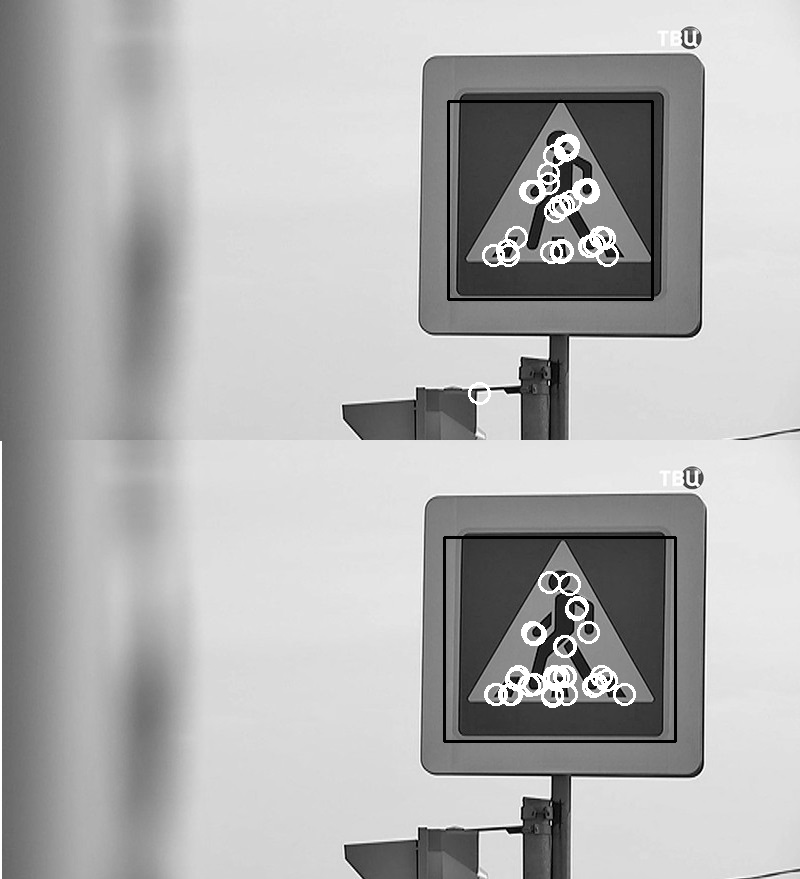

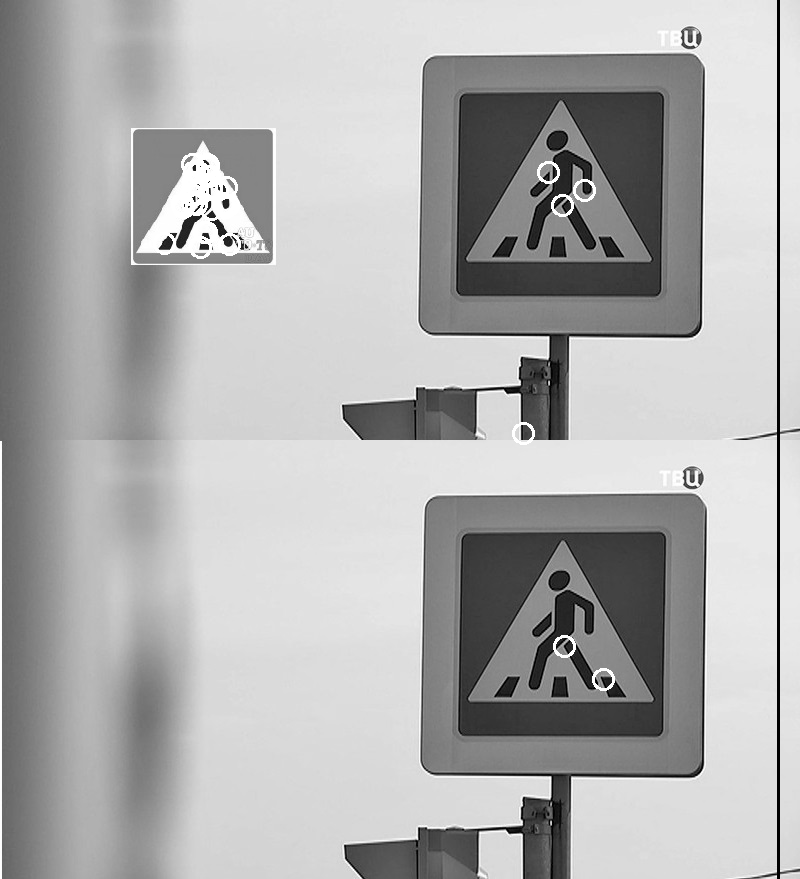

In [11]:
import cv2
import numpy as np
from sklearn.cluster import OPTICS
from google.colab.patches import cv2_imshow

#Abstract class here
class RoadSignDetectorPattern:
  def __init__(self, test_img, query_img):
    self.test_img = test_img
    self.query_img = query_img

  def detect(self):
    pass

  def compare(self, test_kps, test_des, query_kps, query_des):
    pass
  
  def calculateSignCenters(self, query_kps, good_points):
    pass

  def run(self):
    pass

  def changeQueryImage(self, query_img):
    pass

#Specific class here
class RoadSignDetector(RoadSignDetectorPattern):
  def __init__(self, test_img, query_img):
      super().__init__(test_img, query_img)

  def detect(self):
    orb = cv2.ORB_create()
    test_kps, test_des = orb.detectAndCompute(self.test_img, None)
    query_kps, query_des = orb.detectAndCompute(self.query_img, None)
    return test_kps, test_des, query_kps, query_des

  def compare(self, test_kps, test_des, query_kps, query_des):
    flann = cv2.FlannBasedMatcher({"algorithm": 6, "table_number": 6, "key_size": 12, "multi_probe_level": 1}, {"checks": 50})
    matches = flann.knnMatch(test_des, query_des, k=2)
    good_points = []
    for m in matches:
        if m[0].distance < 0.7*m[1].distance:
            good_points.append(m[0])
    if(len(good_points) > 10):
      return good_points
    else:
      return None
    
  def calculateSignCenters(self, query_kps, good_points):
    if(len(good_points) > 10):
      x_gen = [query_kps[i.trainIdx].pt[0] for i in good_points]
      y_gen = [query_kps[i.trainIdx].pt[1] for i in good_points]
      coords = []
      for i, x_coord in enumerate(x_gen):
        coords.append([x_coord, y_gen[i]])

      points_to_clusterize = np.array(coords)
      clust = OPTICS(min_samples=25)
      clust.fit(points_to_clusterize)

      roadsign_kps = []
      i = 0
      while(True):
        points = points_to_clusterize[clust.labels_ == i]
        points = points.astype(int)
        if(points.size != 0):
          temp = []
          for point in points:
            temp.append(point)
          roadsign_kps.append(temp)
        else:
          break
        i += 1
      roadsign_coords = []
      for kps in roadsign_kps:
        x_kps = [i[0] for i in kps]
        y_kps = [i[1] for i in kps]
        roadsign_coords.append([min(x_kps), max(x_kps), min(y_kps), max(y_kps)])
      return roadsign_coords
    else:
      return None
  
  def run(self):
    t_kp, t_des, q_kp, q_des = self.detect()
    success = False
    for i in range(3):
      try:
        good_points = self.compare(t_kp, t_des, q_kp, q_des)
        success = True
        break
      except IndexError:
        pass
    if(success and good_points != None):
      roadsign_centers = self.calculateSignCenters(q_kp, good_points)
      for center in roadsign_centers:
        x_size = center[1]-center[0]
        y_size = center[3]-center[2]
        add_size_x = int(x_size/100*40)
        add_size_y = int(y_size/100*40)
        self.query_img = cv2.rectangle(self.query_img, (center[0]-add_size_x, center[2]-add_size_y), (center[1]+add_size_x, center[3]+add_size_y), (0, 0, 0), 2)
      cv2_imshow(self.query_img)
    else:
      print("Image doesn't contain road signs!")
    
  def changeQueryImage(self, query_img):
    self.query_img = query_img

#Main code here
!wget https://github.com/OSLL/sirius-cv/raw/19_bounding_box_Daniil_Komarov/picture-1.jpg -q
img_test = cv2.imread('/content/picture-1.jpg', cv2.IMREAD_GRAYSCALE)

!wget https://github.com/OSLL/sirius-cv/raw/19_bounding_box_Daniil_Komarov/picture-2.jpg -q
img_query = cv2.imread('/content/picture-2.jpg', cv2.IMREAD_GRAYSCALE)

!wget https://github.com/OSLL/sirius-cv/raw/25_clusterization_Daniil_Komarov/picture-3.jpg -q
img_query2 = cv2.imread('/content/picture-3.jpg', cv2.IMREAD_GRAYSCALE)

rsd = RoadSignDetector(img_test, img_query)
rsd.run()
rsd.changeQueryImage(img_query2)
rsd.run()